# Project Oxford: Emotion analysis example

### This Jupyter notebook shows you how to get started with the Project Oxford <b>Emotion API</b> in Python, and how to visualize your results.

To use this notebook, you will need to get keys to <b>Emotion API</b>. Visit <a href="http://www.projectoxford.ai/emotion">www.projectoxford.ai/emotion</a>, and then the “Try for free” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Emotion API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your key into the variables section below. (Either the primary or the secondary key works.)

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables

_url = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key = '6f7ffca280934f8fbecc7df4a74e6556' #Here you have to paste your primary key
_maxNumRetries = 10


## Helper functions

In [3]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [4]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

## Detect faces from an image retrieved via URL

In [ ]:
# URL direction to image
urlImage = 'https://raw.githubusercontent.com/Microsoft/ProjectOxford-ClientSDK/master/Face/Windows/Data/detection3.jpg'

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None
params = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

# Detect faces from an image stored on disk

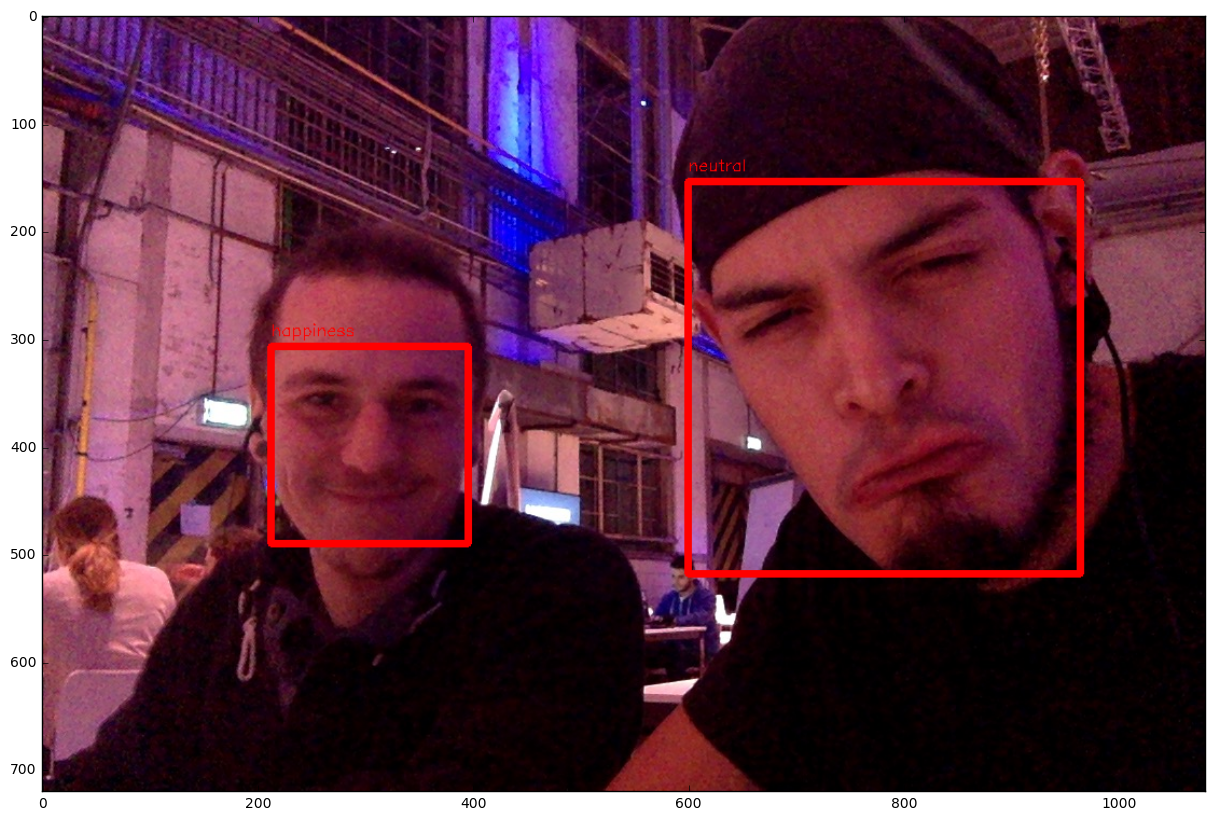

In [6]:
# Load raw image file into memory
pathToFileInDisk = r'/Users/Sergio/Desktop/photo2.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None
params = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )